In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
from skimage.feature import blob_dog
from skimage.color import rgb2hed, rgb2gray
import skimage

In [2]:
def load_img_data(index):
    imgf = 'Dataset/Detection/img{0}/img{0}.bmp'.format(index)
    detf = 'Dataset/Detection/img{0}/img{0}_detection.mat'.format(index)
    img = mpimg.imread(imgf)
    det = loadmat(detf)['detection']
    return img, det

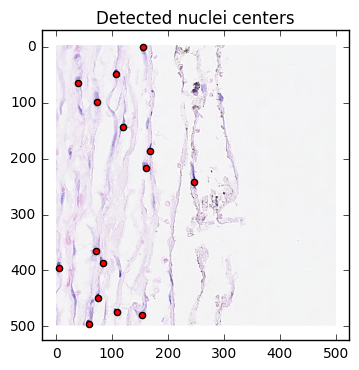

In [3]:
MY_TEST_IMG = 75
img, dets = load_img_data(MY_TEST_IMG)
plt.imshow(img)
plt.scatter(dets[:, 0], dets[:, 1], c='r')
plt.title("Detected nuclei centers")

(38, 3)


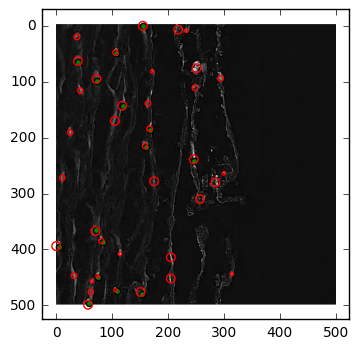

In [4]:
img, dets = load_img_data(MY_TEST_IMG)
grimg = rgb2hed(img)[:, :, 0]
plt.imshow(grimg, cmap='gray')
plt.scatter(dets[:, 0], dets[:, 1], c='g')


blobs_dog = skimage.feature.blob_dog(grimg, min_sigma=3, max_sigma=12, threshold=0.09)
# blobs_dog = blob_dog(grimg, min_sigma=14, max_sigma=17, threshold=0.09)
blobs_dog[:, 2] = blobs_dog[:, 2] * 5**(1/2)

print blobs_dog.shape

fig = plt.gcf()
ax = fig.gca()
for blob in blobs_dog:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='r', linewidth=1, fill=False)        
        ax.add_artist(c)

/nfs/ug/groups/projects/scene-net/tf_gpu/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


(119, 3)


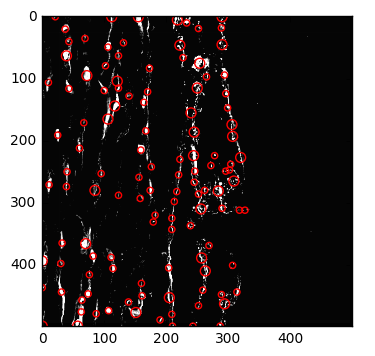

In [5]:
img, dets = load_img_data(MY_TEST_IMG)
img_hed = skimage.color.rgb2hed(img)[:,:,0]
p2, p98 = np.percentile(img_hed, (2, 98))
img_rescale = skimage.exposure.rescale_intensity(img_hed, in_range=(p2, p98))
img_adapteq = skimage.exposure.equalize_adapthist(img_rescale, clip_limit=0.02)

# plt.imshow(img)
# plt.figure()
# plt.imshow(img_hed, cmap='gray')
# plt.figure()
# plt.imshow(img_rescale, cmap='gray')
# plt.figure()
plt.imshow(img_adapteq, cmap='gray')

# plt.scatter(dets[:, 0], dets[:, 1], c='g')

blobs_dog = skimage.feature.blob_dog(img_adapteq, min_sigma=5, max_sigma=12, threshold=0.09)
# blobs_dog = blob_dog(grimg, min_sigma=14, max_sigma=17, threshold=0.09)
blobs_dog[:, 2] = blobs_dog[:, 2] * 5**(1/2)

print blobs_dog.shape

fig = plt.gcf()
ax = fig.gca()
for blob in blobs_dog:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)        
        ax.add_artist(c)

In [6]:
RESCALE_PERC = (2, 98)
HIST_CLIP = 0.02
BLOB_MIN_SIG = 3
BLOB_MAX_SIG = 12
BLOB_THRES = 0.09

In [7]:
def get_blob_detections(img, rescale_perc, 
                        hist_clip, blob_min_sig, 
                        blob_max_sig, blob_thres):    
    img_hed = skimage.color.rgb2hed(img)[:,:,0]
#     pL, pH = np.percentile(img_hed, rescale_perc)
#     img_rescale = skimage.exposure.rescale_intensity(img_hed, in_range=(pL, pH))
#     img_adapteq = skimage.exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip)
    blobs_dog = skimage.feature.blob_dog(img_hed, min_sigma=blob_min_sig, 
                                         max_sigma=blob_max_sig, threshold=blob_thres)
    return blobs_dog[:, 0:2]

In [8]:
# Takes an image and returns blob_detected patches
# patches of given size (PATCH_SIZE)
# as a list of (patch, center) tuples
def get_blob_patches(img_id, 
                  deconv=False,
                  shuffle=False, 
                  height=27, 
                  width=27, cell_rad=0):
    img, _ = load_img_data(img_id);
    blobs = get_blob_detections(img, RESCALE_PERC, HIST_CLIP, BLOB_MIN_SIG, BLOB_MAX_SIG, BLOB_THRES)        
    
    dy = height/2
    dx = width/2
        
    # create a padded matrix of zeros to set to one for detected nuclei with radius cell_rad
    det = np.zeros((img.shape[0]+2*cell_rad, img.shape[1]+2*cell_rad), dtype=np.bool)
    for x, y in blobs:
        det[x-cell_rad:x+cell_rad+1, y-cell_rad:y+cell_rad+1] = 1
    
    det = det[cell_rad:-(cell_rad+1), cell_rad:-(cell_rad+1)] # crop out the padding
    patch_coords = np.array(np.nonzero(det)).T
    
    img = np.pad(img, ((dy+1,), (dx+1,), (0,)), 'symmetric')
            
    patches = []
    # pos eg
    for x,y in patch_coords:
        x += dy+1
        y += dx+1
        patch = img[y-dy:y+dy+1, x-dx:x+dx+1]
        if deconv:
            patch = rgb2hed(patch)[:,:,0]
        else:
            patch = rgb2gray(patch)
        patches.append(patch)

    patches = np.stack(patches)
    return patches.astype(np.uint8), patch_coords.astype(np.uint16)

/nfs/ug/groups/projects/scene-net/tf_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


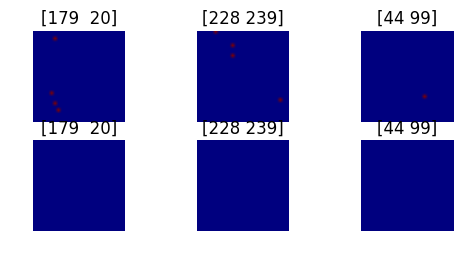

In [9]:
def test_patch_examples(img_id = MY_TEST_IMG, my_num_to_see = 3):
    p, c = get_blob_patches(img_id, cell_rad=6)
    p2, c2 = get_blob_patches(img_id, deconv=True, cell_rad=6)
    
    r = np.random.permutation(p.shape[0])[:my_num_to_see]
    
    for i in range(my_num_to_see):
        plt.subplot(int('{:}{:}{:}'.format(3,my_num_to_see,i+1)))
        plt.imshow(p[r[i],:,:])
        plt.title('{:}'.format(c[r[i]]))
        plt.axis('off')
        plt.subplot(
            int('{:}{:}{:}'.format(3,my_num_to_see,i+1+my_num_to_see)))
        plt.imshow(p2[r[i],:,:])
        plt.title('{:}'.format(c2[r[i]]))
        plt.axis('off')

test_patch_examples();


In [10]:
def load_data(img_ids,               
              deconv, 
              height, 
              width, 
              cell_radius):
    patches, centers = [], []
    for img_id in img_ids:
        p, c = get_blob_patches(
            img_id, 
            deconv=deconv, 
            height=height,
            width=width,
            cell_rad=cell_radius)
        patches.append(p)
        c = np.hstack((c, np.ones((c.shape[0], 1)) * img_id))
        centers.append(c)
        print "Loaded img", img_id
    patches = np.concatenate(patches)
    centers = np.concatenate(centers)
    data = {
        'patches': patches,
        'centers': centers,
    }
    return data

In [11]:
NUM_IMGS = 100
NUM_TEST_IMGS = int(NUM_IMGS*0.2)
CELL_RADIUS = 6 # In pixels
PATCH_SIZE_H = 27
PATCH_SIZE_W = 27
DECONV = True
POS_THRESHOLD = 0.35
BATCH_SIZE = 300
EPOCHS = 10

In [12]:
try:
    del data
except:
    pass
print "Loading data"
data = load_data(img_ids=range(NUM_IMGS-NUM_TEST_IMGS+1, NUM_IMGS+1),
    deconv=False,
    height=PATCH_SIZE_H,
    width=PATCH_SIZE_W,
    cell_radius=CELL_RADIUS)

Loading data


/nfs/ug/groups/projects/scene-net/tf_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Loaded img 81
Loaded img 82
Loaded img 83
Loaded img 84
Loaded img 85
Loaded img 86
Loaded img 87
Loaded img 88
Loaded img 89
Loaded img 90
Loaded img 91
Loaded img 92
Loaded img 93
Loaded img 94
Loaded img 95
Loaded img 96
Loaded img 97
Loaded img 98
Loaded img 99
Loaded img 100


In [13]:
for k,v in data.items():
    print k, v.shape

patches (728087, 27, 27)
centers (728087, 3)


In [14]:
try:
    sess.close()
except:
    pass

sess = tf.InteractiveSession()

saver = tf.train.import_meta_graph('detection_models/cp_cnn_model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint("detection_models/"))

In [15]:
g = tf.get_default_graph()
inference_tensor = g.get_tensor_by_name('detector_1/7_linear/BiasAdd:0')
patch_tensor = g.get_tensor_by_name('Placeholder:0')

In [16]:
def eval_predictions(preds, centers, cell_rad=CELL_RADIUS):    
    precision = 0
    recall = 0
    imgs = np.unique(centers[:, 2])

    for img_id in imgs:
        img_preds_mask = (centers[:, 2] == img_id)
        img_preds = preds[img_preds_mask]
        pred_centers = centers[img_preds_mask][:, 0:2].astype(np.int32)
        img, dets = load_img_data(int(img_id))
        assert img_preds.shape[0] == pred_centers.shape[0]
        
        # create a padded matrix of zeros to set to one for detected nuclei with radius cell_rad
        det_matrix = np.zeros((img.shape[0]+2*cell_rad, img.shape[1]+2*cell_rad), dtype=np.bool)
        for x, y in dets:
            det_matrix[x-cell_rad:x+cell_rad+1, y-cell_rad:y+cell_rad+1] = 1

        det_matrix = det_matrix[cell_rad:-(cell_rad), cell_rad:-(cell_rad)] # crop out the padding
        
        num_pos = dets.shape[0]
        
        pos_preds = np.zeros(img.shape[0:2], dtype=np.float32)
        
        pos_preds[pred_centers[:, 1], pred_centers[:, 0]] = img_preds[:,0]
        pos_preds[pos_preds >= POS_THRESHOLD] = 1
        pos_preds[pos_preds < POS_THRESHOLD] = 0
        trupos = np.count_nonzero(pos_preds.astype(np.bool) & det_matrix)
        pospreds = np.count_nonzero(pos_preds)
        precision += trupos / float(pospreds)
        recall += trupos / float(num_pos)
    
    precision /= imgs.shape[0]
    recall /= imgs.shape[0]
    
    return precision, recall
    
    
    

In [31]:
total_precision, total_recall, total_f1 = 0, 0, 0
for i in range(0, data['patches'].shape[0], BATCH_SIZE):
    [tp] = sess.run([inference_tensor], feed_dict={
        patch_tensor:np.expand_dims(data['patches'][i:i+BATCH_SIZE], -1),
    })
    p, r, f = eval_predictions(tp, data['centers'][i:i+BATCH_SIZE])
    total_precision += p
    total_recall += r

total_precision /= (data['patches'].shape[0]/BATCH_SIZE)
total_recall /= (data['patches'].shape[0]/BATCH_SIZE)
f1 = 2 * total_precision * total_recall / (total_precision+total_recall)

print total_precision, total_recall, f1


/nfs/ug/groups/projects/scene-net/tf_gpu/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.747346329222 0.75470035346 0.751005338681
